In [2]:
# pyright: reportMissingModuleSource=false
from tensorflow.keras import models, layers, optimizers, callbacks
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os, random

c:\Users\sihmars\OneDrive\Desktop\Genetic proj\tf_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
df = pd.read_csv("Data\METABRIC_RNA_Mutation.csv")
print(df.shape)
print(df.columns[:50])
df.head()

NameError: name 'np' is not defined

In [3]:
missing_values = df.isnull().sum()
print("Number of missing values per column:\n", missing_values[missing_values > 0])


Number of missing values per column:
 type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
tumor_other_histologic_subtype     15
primary_tumor_laterality          106
mutation_count                     45
oncotree_code                      15
3-gene_classifier_subtype         204
tumor_size                         20
tumor_stage                       501
death_from_cancer                   1
dtype: int64


In [4]:
numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns

print(f"Numeric columns: {len(numeric_cols)} | Categorical columns: {len(categorical_cols)}")

Numeric columns: 503 | Categorical columns: 190


In [6]:
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()
        if len(mode_val) > 0:
            df[col].fillna(mode_val[0], inplace=True)
        else:
            df[col].fillna("Unknown", inplace=True)

print("\nRemaining missing values (should be 0):")
print(df.isnull().sum()[df.isnull().sum() > 0])


Remaining missing values (should be 0):
Series([], dtype: int64)


C:\Users\sihmars\AppData\Local\Temp\ipykernel_5512\2887209305.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val[0], inplace=True)


In [8]:
TARGET_COL = 'pam50_+_claudin-low_subtype' 
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataset!")

le = LabelEncoder()
df[TARGET_COL] = le.fit_transform(df[TARGET_COL].astype(str))
class_names = le.classes_.tolist()
print(f"Encoded target classes ({len(class_names)}):", class_names)

feature_cols = [c for c in df.columns if c != TARGET_COL]

Encoded target classes (7): ['Basal', 'Her2', 'LumA', 'LumB', 'NC', 'Normal', 'claudin-low']


In [9]:
X = df[feature_cols]
y = df[TARGET_COL]

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print(f"\nNumeric columns: {len(numeric_cols)} | Categorical columns: {len(categorical_cols)}")


Numeric columns: 503 | Categorical columns: 189


In [7]:
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
print("\n✅ Encoding + Scaling complete.")
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


NameError: name 'categorical_cols' is not defined

In [6]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y, palette="Set2")
plt.title("Class Distribution - Cancer Subtypes")
plt.xlabel("Subtype (encoded)")
plt.ylabel("Count")
plt.show()

NameError: name 'y' is not defined

<Figure size 800x500 with 0 Axes>

In [4]:
plt.figure(figsize=(8,5))
sns.countplot(x=[class_names[i] for i in y], palette="Set2")
plt.title("Class Distribution - Cancer Subtypes (Labels)")
plt.xlabel("Subtype")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


NameError: name 'plt' is not defined

In [14]:
numeric_summary = X.describe().T
print("Numeric Feature Summary (first 10):")
display(numeric_summary.head(10))

Numeric Feature Summary (first 10):


,count,mean,std,min,25%,50%,75%,max
patient_id,1904.0,-5.970947e-17,1.000263,-1.663366,-1.283148,0.342903,0.684633,1.432239
age_at_diagnosis,1904.0,0.000000e+00,1.000263,-3.017814,-0.748503,0.052634,0.732580,2.713073
type_of_breast_surgery,1904.0,6.034664e-01,0.489306,0.000000,0.000000,1.000000,1.000000,1.000000
cancer_type,1904.0,5.252101e-04,0.022917,0.000000,0.000000,0.000000,0.000000,1.000000
cancer_type_detailed,1904.0,1.417017e+00,0.971179,0.000000,1.000000,1.000000,1.000000,5.000000
cellularity,1904.0,8.518908e-01,0.934602,0.000000,0.000000,0.000000,2.000000,2.000000
chemotherapy,1904.0,-2.985474e-17,1.000263,-0.512445,-0.512445,-0.512445,-0.512445,1.951430
cohort,1904.0,2.388379e-16,1.000263,-1.338368,-1.338368,0.289909,0.289909,1.918185
er_status_measured_by_ihc,1904.0,7.746849e-01,0.417899,0.000000,1.000000,1.000000,1.000000,1.000000
er_status,1904.0,7.662815e-01,0.423306,0.000000,1.000000,1.000000,1.000000,1.000000


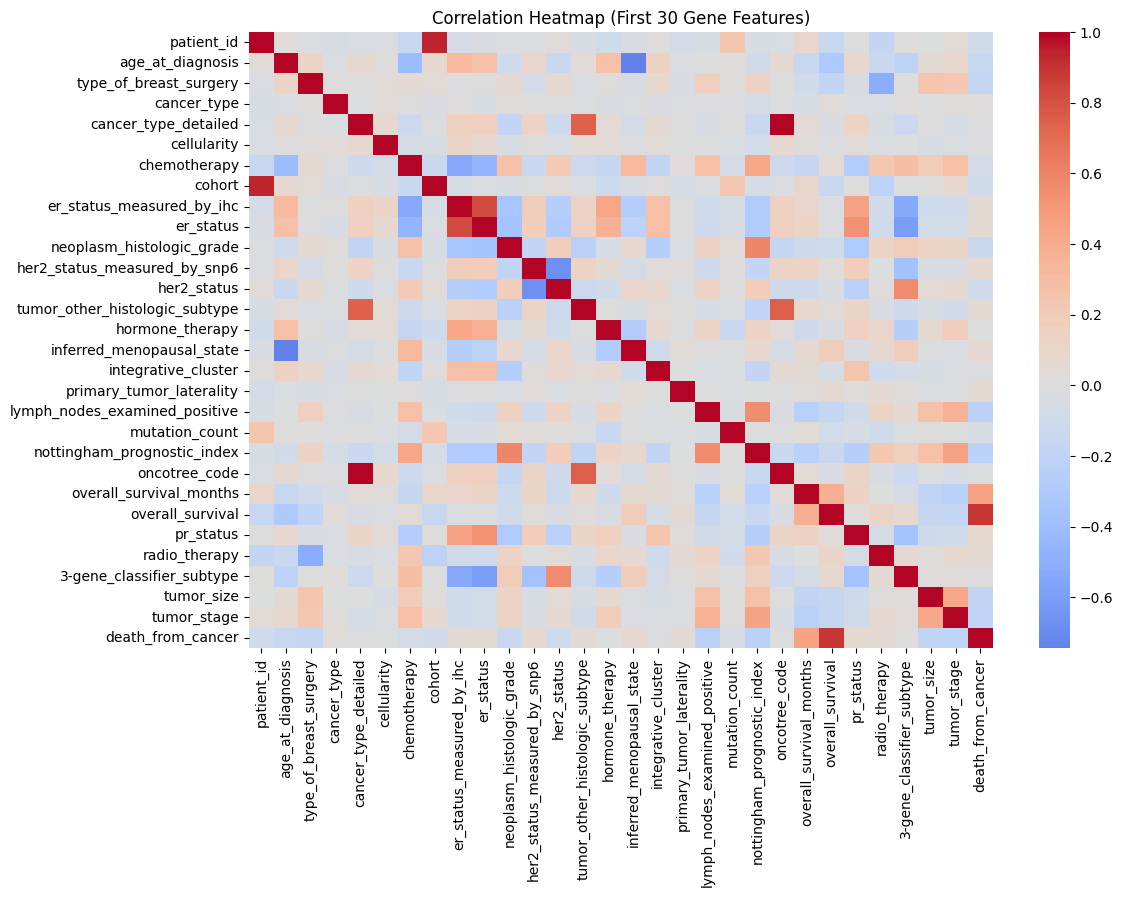

In [15]:
plt.figure(figsize=(12,8))
corr_sample = X.iloc[:, :30].corr()
sns.heatmap(corr_sample, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (First 30 Gene Features)")
plt.show()

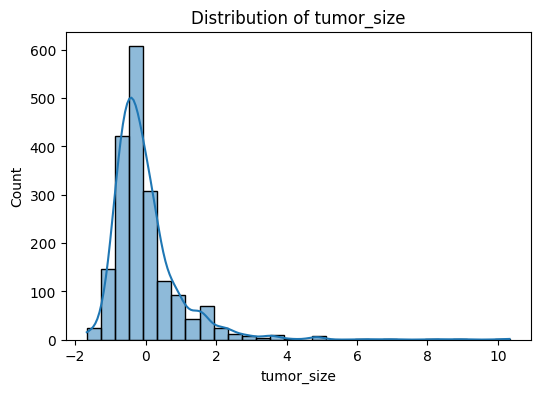

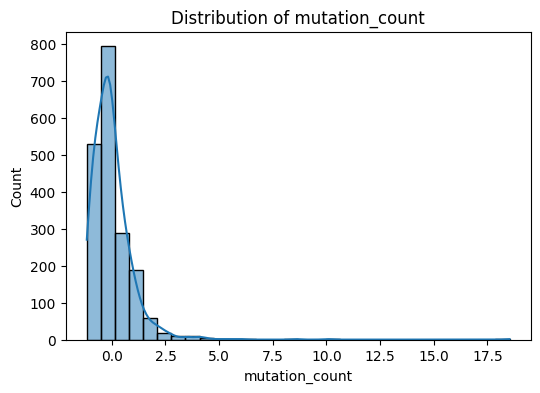

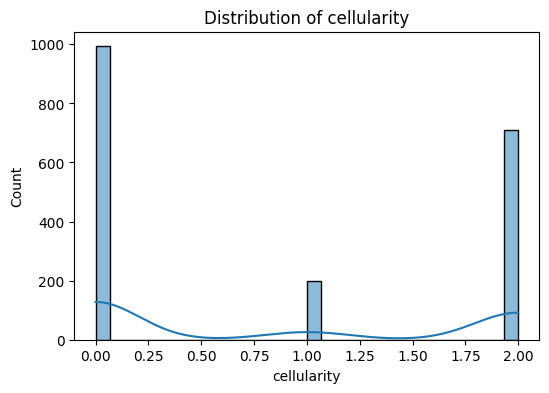

In [16]:
for col in ['tumor_size', 'mutation_count', 'cellularity']:
    if col in X.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(X[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.show()


In [17]:
feature_variances = X.var().sort_values(ascending=True)
low_var = feature_variances[feature_variances < 1e-5]
print(f"Number of near-constant features: {len(low_var)}")
if len(low_var) > 0:
    print("\nThese could be dropped later:")
    print(low_var.head(10))

Number of near-constant features: 0
